# install

In [ ]:
!pip install googletrans==4.0.0-rc1
!pip install TTS
!pip install pydub
!apt-get install ffmpeg -y
!pip install SpeechRecognition
!pip install speechbrain
# !pip install --upgrade --force-reinstall numpy
# !pip install --upgrade --force-reinstall scipy
# !pip install --upgrade --force-reinstall torch torchvision torchaudio
# !pip install --upgrade --force-reinstall transformers


# import numpy
# import scipy
# import torch
# import transformers

# print("NumPy version:", numpy.__version__)
# print("SciPy version:", scipy.__version__)
# print("PyTorch version:", torch.__version__)
# print("Transformers version:", transformers.__version__)
!pip install praat-parselmouth



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=e72382fd939539ac89e431ecf55a7a0d651df92ee2c7350cc40bc42bd6e4d8d5
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

In [ ]:
%matplotlib inline


#import

In [ ]:
import os
import numpy as np
import torch
import torchaudio
import soundfile as sf
from google.colab import files, drive
from googletrans import Translator
from TTS.api import TTS
from pydub import AudioSegment
import speech_recognition as sr
from IPython.display import Audio, display
from scipy.spatial.distance import cosine
import nltk
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import unicodedata
import re
from speechbrain.pretrained import SpeakerRecognition
from pydub.silence import detect_nonsilent, detect_silence
import shutil
import time

import parselmouth
from parselmouth.praat import call
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-2-ddc44c3acbb2>:21: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import SpeakerRecognition


# Full code all together - Don't use




In [ ]:
class MultilingualVoiceTranslator:
    def __init__(self):
        # Check for CUDA
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        # Initialize TTS Model
        try:
            self.tts = TTS(model_name="tts_models/multilingual/multi-dataset/your_tts", progress_bar=False).to(self.device)
        except Exception as e:
            print(f"Error loading TTS model: {e}")
            raise

    def play_audio(self, audio_path):
        """Play an audio file."""
        try:
            display(Audio(audio_path, autoplay=True))
        except Exception as e:
            print(f"Audio playback error: {e}")

    def convert_to_wav(self, file_path):
        """Convert any audio file to WAV format."""
        try:
            wav_path = "converted_audio.wav"
            audio = AudioSegment.from_file(file_path)
            audio.export(wav_path, format="wav")
            return wav_path
        except Exception as e:
            print(f"Audio conversion error: {e}")
            return None

    def transcribe_audio(self, wav_path, input_language):
        """Transcribe speech from an audio file."""
        recognizer = sr.Recognizer()
        try:
            with sr.AudioFile(wav_path) as source:
                print("Listening to the audio...")
                audio_data = recognizer.record(source)
                print("Transcribing audio...")
                text = recognizer.recognize_google(audio_data, language=input_language)
                return text
        except sr.UnknownValueError:
            return "Sorry, the speech could not be understood."
        except sr.RequestError as e:
            return f"Speech recognition service error: {e}"

    def translate_text(self, text, target_language):
        """Translate text into the specified language."""
        translator = Translator()
        try:
            translation = translator.translate(text, dest=target_language)
            return translation.text
        except Exception as e:
            return f"Error in translation: {e}"

    def split_sentences(self, text):
        """Split text into sentences for better prosody alignment."""
        return sent_tokenize(text)

    def clone_voice_with_prosody(self, reference_audio_path, sentences):
        """Clone voice with improved prosody and generate new speech."""
        try:
            output_path = 'translated_cloned_voice_output_with_prosody.wav'
            combined_audio = None

            for sentence in sentences:
                temp_output_path = f"temp_{hash(sentence)}.wav"
                self.tts.tts_to_file(
                    text=sentence,
                    file_path=temp_output_path,
                    speaker_wav=reference_audio_path,
                    language='en',
                    emotion='neutral',
                    use_prosody=True,
                    speed_regulator=1.0,
                    adjust_volume=True
                )

                segment_audio = AudioSegment.from_file(temp_output_path)
                combined_audio = segment_audio if combined_audio is None else combined_audio + segment_audio

            combined_audio.export(output_path, format="wav")
            print("\n🎙️ Voice cloning with enhanced prosody complete!")
            return output_path #, voice_characteristics
        except Exception as e:
            print(f"Voice cloning error: {e}")
            return None, None


# ---------------------------------------------- Evaluation Part ---------------------------------------

def evaluate_model(test_audio_path, generated_audio_path, test_text, output_transcription_text):
    """Evaluate the model with test audio."""
    print("\n--- Evaluating Model ---")

    def compare_voice_characteristics(test_audio, original_audio):
        try:
            # Load the Speaker Recognition model
            recognizer = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="tmp_model")

            # Compute similarity between the original and test audio
            similarity_score = recognizer.verify_files(original_audio, test_audio)
            return similarity_score[0].item()
        except Exception as e:
            print(f"Error comparing voice characteristics: {e}")
            return 0.0


    def compare_text_similarity(test_text, output_text):
        def normalize_text(text):
            # Remove Unicode control characters (e.g., \u200f)
            text = ''.join(ch for ch in text if not unicodedata.category(ch).startswith('C'))
            # Normalize spacing
            text = re.sub(r'\s+', ' ', text).strip()
            return text

        try:
            # Check if the test text is valid and meaningful
            if test_text.lower() in {"sorry, the speech could not be understood.", ""}:
                print("Test text is not valid for comparison. Skipping text similarity evaluation.")
                return None

            test_text = normalize_text(test_text)
            output_text = normalize_text(output_text)
            test_words = set(test_text.split())
            output_words = set(output_text.split())
            print(f"Test words: {test_text}")
            print(f"Output words: {output_text}")
            similarity = len(test_words & output_words) / len(test_words | output_words)
            return similarity
        except Exception as e:
            print(f"Error comparing text similarity: {e}")
            return None

    def time_stretch(audio_path, target_duration):
        """
        Time-stretch the audio to match the target duration without changing pitch.
        """
        try:
            wav, sr = torchaudio.load(audio_path)
            current_duration = wav.size(1) / sr
            stretch_factor = target_duration / current_duration
            stretched_audio = torchaudio.transforms.Resample(
                orig_freq=sr, new_freq=int(sr / stretch_factor)
            )(wav)
            return stretched_audio, sr
        except Exception as e:
            print(f"Error during time-stretching: {e}")
            return None, None


    def extract_pauses(audio_path, silence_thresh=-40, min_silence_len=300):
        """
        Extract pauses from audio by detecting silent segments.
        """
        audio = AudioSegment.from_file(audio_path)
        silence = detect_silence(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)
        pauses = [(start / 1000, end / 1000) for start, end in silence]  # Convert to seconds
        return pauses


    def normalize_recordings(test_audio, generated_audio):
        """
        Normalize the lengths of two recordings by time-stretching the shorter one.
        """
        try:
            # Calculate durations
            test_duration = AudioSegment.from_file(test_audio).duration_seconds
            generated_duration = AudioSegment.from_file(generated_audio).duration_seconds

            # Determine the longer and shorter recording
            if test_duration > generated_duration:
                stretched_audio, sr = time_stretch(generated_audio, test_duration)
                normalized_generated_path = "normalized_generated.wav"
                torchaudio.save(normalized_generated_path, stretched_audio, sr)
                return test_audio, normalized_generated_path
            elif generated_duration > test_duration:
                stretched_audio, sr = time_stretch(test_audio, generated_duration)
                normalized_test_path = "normalized_test.wav"
                torchaudio.save(normalized_test_path, stretched_audio, sr)
                return normalized_test_path, generated_audio
            else:
                # Already normalized
                return test_audio, generated_audio
        except Exception as e:
            print(f"Error normalizing recordings: {e}")
            return None, None


    def compare_prosody(test_audio, generated_audio, silence_threshold=0.5):
        """
        Compare prosody of the test and generated audio based on pauses.
        """
        try:
            # Normalize lengths
            test_audio, generated_audio = normalize_recordings(test_audio, generated_audio)
            if not test_audio or not generated_audio:
                raise ValueError("Failed to normalize recordings.")

            # Extract pauses
            test_pauses = extract_pauses(test_audio)
            generated_pauses = extract_pauses(generated_audio)

            if not test_pauses or not generated_pauses:
                raise ValueError("Failed to extract pauses from one or both audio files.")

            # Compute pause durations
            test_pause_durations = np.array([p[1] - p[0] for p in test_pauses])
            generated_pause_durations = np.array([p[1] - p[0] for p in generated_pauses])

            # Normalize pause durations
            min_len = min(len(test_pause_durations), len(generated_pause_durations))
            test_pause_durations = test_pause_durations[:min_len]
            generated_pause_durations = generated_pause_durations[:min_len]

            # Compare pauses
            pause_similarity = 1 - np.linalg.norm(test_pause_durations - generated_pause_durations) / max(
                np.linalg.norm(test_pause_durations), 1e-5
            )
            return pause_similarity
        except Exception as e:
            print(f"Error comparing prosody: {e}")
            return 0.0


    print("\n--- Evaluation Results ---")
    voice_similarity = compare_voice_characteristics(test_audio_path, generated_audio_path) ### Voice Similarity test
    print("\n")
    print(f"Voice Characteristics Similarity:  {voice_similarity:.2f}")
    print("\n")

    text_similarity = compare_text_similarity(test_text, output_transcription_text) ### Text Similarity test
    if text_similarity is not None:
        print(f"Text Similarity: {text_similarity:.2f}")
        print("\n")

    else:
        print("Text similarity evaluation was skipped.")
        print("\n")

    pause_similarity = compare_prosody(test_audio_path, generated_audio_path)   ### Prosody/Pause Similarity test
    print(f"Pause Similarity: {pause_similarity:.2f}")
    print("\n")



#------------------------------- run demo---------------------------------------------

def multilingual_voice_translation_demo():
    print("\n--- Multilingual Voice Translation and Cloning Demo ---")

    # Upload reference audio
    print("\n📤 Please upload an audio file.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return
    audio_path = list(uploaded.keys())[0]

    # Create instance
    translator_cloner = MultilingualVoiceTranslator()

    # Play the uploaded audio
    print("\nPlaying the uploaded audio...")
    translator_cloner.play_audio(audio_path)

    # Convert audio to WAV
    wav_path = translator_cloner.convert_to_wav(audio_path)
    if not wav_path:
        print("Audio conversion failed. Exiting.")
        return

    # Get input language
    input_language = input("\nEnter the input language code (e.g., 'en' for English, 'es' for Spanish): ").strip()

    # Transcribe the audio
    transcription = translator_cloner.transcribe_audio(wav_path, input_language)
    print("\nTranscription of the audio:")
    print(transcription)

    # Split transcription into sentences
    sentences = translator_cloner.split_sentences(transcription)

    # Get target language
    language = input("\nEnter the target language code (e.g., 'es' for Spanish, 'fr' for French): ").strip()

    # Translate sentences individually
    translated_sentences = [translator_cloner.translate_text(sentence, language) for sentence in sentences]
    print("\nTranslated sentences:")
    for sentence in translated_sentences:
        print(sentence)

    # Generate the cloned voice with enhanced prosody for the translated text
    print("\nGenerating cloned voice with enhanced prosody for the translated text...")
    output_audio_path = translator_cloner.clone_voice_with_prosody(audio_path, translated_sentences)
    print(f"output audio path:  {output_audio_path} ")
    if not output_audio_path:
        print("Failed to generate audio. Exiting.")
        return

    print("\nPlaying the generated audio...")
    translator_cloner.play_audio(output_audio_path)

    print("\nDownloading the generated audio...")
    files.download(output_audio_path)

    evaluate = input("\nDo you want to evaluate the output? (yes/no): ").strip().lower()
    if evaluate == "yes":
        print("\n📤 Please upload the test audio file for evaluation.")
        uploaded_test = files.upload()
        if not uploaded_test:
            print("No test file uploaded. Exiting.")
            return

        test_audio_path = list(uploaded_test.keys())[0]
        test_wav_path = translator_cloner.convert_to_wav(test_audio_path) # convert test file to wav

        print("\n Play the test audio")
        translator_cloner.play_audio(test_wav_path) # play test audio

        test_transcription = input("\nEnter the transcription of the test audio: ").strip()
        print("\nTranscription of the test audio:")
        print(test_transcription)
        output_sentence =' '.join(translated_sentences)
        evaluate_model(test_wav_path, output_audio_path, test_transcription,output_sentence)

# Run the demo
multilingual_voice_translation_demo()



--- Multilingual Voice Translation and Cloning Demo ---

📤 Please upload an audio file.


Saving 20250125_174756.mp3 to 20250125_174756.mp3
Using device: cpu
 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


/usr/local/lib/python3.11/dist-packages/TTS/utils/io.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_location, **kwargs)


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400
 > External Speaker Encoder Loaded !!
 > initialization of language-embedding layers.
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10


Enter the input language code (e.g., 'en' for English, 'es' for Spanish): iw
Listening to the audio...
Transcribing audio...

Transcription of the audio:
אתה יודע מה התאריך היום או באיזה שנה אנחנו

Enter the target language code (e.g., 'es' for Spanish, 'fr' for French): en

Translated sentences:
You know what date of the day or in what year we

Generating cloned voice with enhanced prosody for the translated text...
 > Text splitted to sentences.
['You know what date of the day or in what year we']
 > Processing time: 3.5472235679626465
 > Real-time factor: 1.1543194168443367

🎙️ Voice cloning with enhanced prosody complete!
output audio path:  translated_cloned_voice_output_with_prosody.wav 

Playing the generated audio...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: Interrupted by user

-------------------------------------------------------------------------------

#Separate Parts



#Usefull functions

mount google drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Folder of files --> list

In [ ]:
def list_files_in_drive_folder(folder_name=None):
    """
    Lists all files in a folder on Google Drive.

    :param folder_path: Path to the folder in Google Drive (e.g., '/content/drive/My Drive/FolderName')
    :return: List of file paths
    """

    # Specify the folder path (replace with your folder path in Google Drive)
    folder_path = '/content/drive/My Drive/generative_project/'
    if  not folder_name:
      folder_name = input("\nEnter the folder name  ").strip()
    folder_path = folder_path + folder_name
    if not os.path.exists(folder_path):
        print(f"Error: The folder path '{folder_path}' does not exist.")
        return []

    files_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            files_list.append(os.path.join(root, file))

    print("\nList of files in the folder:")
    for file in files_list:
        print(file)

    return files_list


normalize audio

In [ ]:
from pydub.effects import normalize

def normalize_audio(file_path,normalized_path):
    """
    Normalize the volume of an audio file and return the path to the normalized audio file.

    Args:
        file_path (str): Path to the input audio file.

    Returns:
        str: Path to the normalized audio file.
    """
    try:
        # Load the audio file
        audio = AudioSegment.from_file(file_path)

        # Normalize the audio
        normalized_audio = normalize(audio)

        # Export the normalized audio to a temporary file
        normalized_audio.export(normalized_path, format="wav")

        return normalized_path
    except Exception as e:
        print(f"Error normalizing audio: {e}")
        return None


Plot Histogram

In [ ]:
def plot_histogram(
    datasets, bins=10,
    title="Multiple Histograms",
    xlabel="Score",
    ylabel="Frequency",
    labels=None
):
    """
    Plot multiple datasets as overlapping histograms on the same figure.

    Args:
        datasets (list of lists): A list of datasets to plot.
        bins (int): Number of bins for the histograms.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        labels (list of str): Labels for each dataset. Must match the number of datasets.
    """
    plt.figure(figsize=(8, 6))

    # Assign default labels if none are provided
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(datasets))]

    for i, data in enumerate(datasets):
        counts, bin_edges = np.histogram(data, bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, counts, label=labels[i], linewidth=2)

    # Add titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.legend()
    plt.show()


# Class MultilingualVoiceTranslator

In [ ]:
class MultilingualVoiceTranslator:
    def __init__(self):
        # Check for CUDA
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        # Initialize TTS Model
        try:
            self.tts = TTS(model_name="tts_models/multilingual/multi-dataset/your_tts", progress_bar=False).to(self.device)
        except Exception as e:
            print(f"Error loading TTS model: {e}")
            raise

    def play_audio(self, audio_path):
        """Play an audio file."""
        try:
            display(Audio(audio_path, autoplay=True))
        except Exception as e:
            print(f"Audio playback error: {e}")

    def convert_to_wav(self, file_path):
        """Convert any audio file to WAV format."""
        try:
            # Extract the base name and extension of the input file
            base_name = os.path.basename(file_path)
            name_without_extension = os.path.splitext(base_name)[0]

            # Create a unique output filename by appending .wav
            wav_path = f"{name_without_extension}_converted.wav"

            # Load the audio file and export it as WAV
            audio = AudioSegment.from_file(file_path)
            audio.export(wav_path, format="wav")

            return wav_path
        except Exception as e:
            print(f"Audio conversion error: {e}")
            return None

    def transcribe_audio(self, wav_path, input_language):
        """Transcribe speech from an audio file."""
        recognizer = sr.Recognizer()
        try:
            with sr.AudioFile(wav_path) as source:
                print("Listening to the audio...")
                audio_data = recognizer.record(source)
                print("Transcribing audio...")
                text = recognizer.recognize_google(audio_data, language=input_language)
                return text
        except sr.UnknownValueError:
            return "Sorry, the speech could not be understood."
        except sr.RequestError as e:
            return f"Speech recognition service error: {e}"

    def translate_text(self, text, target_language):
        """Translate text into the specified language."""
        translator = Translator()
        try:
            translation = translator.translate(text, dest=target_language)
            return translation.text
        except Exception as e:
            return f"Error in translation: {e}"

    def split_sentences(self, text):
        """Split text into sentences for better prosody alignment."""
        return sent_tokenize(text)

    def clone_voice_with_prosody(self, reference_audio_path, sentences, iter):
        """Clone voice with improved prosody and generate new speech."""
        try:
            output_path = 'reference_audio_path'
            output_path += str(iter)+'.wav'
            # output_path = 'translated_cloned_voice_output_with_prosody.wav'
            combined_audio = None

            for sentence in sentences:
                temp_output_path = f"temp_{hash(sentence)}.wav"
                self.tts.tts_to_file(
                    text=sentence,
                    file_path=temp_output_path,
                    speaker_wav=reference_audio_path,
                    language='en',
                    emotion='neutral',
                    use_prosody=True,
                    speed_regulator=1.0,
                    adjust_volume=True
                )

                segment_audio = AudioSegment.from_file(temp_output_path)
                combined_audio = segment_audio if combined_audio is None else combined_audio + segment_audio

            combined_audio.export(output_path, format="wav")
            print("\n🎙️ Voice cloning with enhanced prosody complete!")
            return output_path
        except Exception as e:
            print(f"Voice cloning error: {e}")
            return None




#Evaluation function


In [ ]:
def evaluate_model(test_audio_path, generated_audio_path, test_text = None, output_transcription_text = None, iter = None):
    """Evaluate the model with test audio."""

    def compare_voice_characteristics(test_audio, original_audio):
        try:
            # Load the Speaker Recognition model
            recognizer = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="tmp_model")

            # Compute similarity between the original and test audio
            similarity_score = recognizer.verify_files(original_audio, test_audio)
            return similarity_score[0].item()
        except Exception as e:
            print(f"Error comparing voice characteristics: {e}")
            return 0.0


    def compare_text_similarity(test_text, output_text):
        def normalize_text(text):
            # Remove Unicode control characters (e.g., \u200f)
            text = ''.join(ch for ch in text if not unicodedata.category(ch).startswith('C'))
            # Normalize spacing
            text = re.sub(r'\s+', ' ', text).strip()
            return text

        try:
            # Check if the test text is valid and meaningful
            if test_text.lower() in {"sorry, the speech could not be understood.", ""}:
                print("Test text is not valid for comparison. Skipping text similarity evaluation.")
                return None

            test_text = normalize_text(test_text)
            output_text = normalize_text(output_text)
            test_words = set(test_text.split())
            output_words = set(output_text.split())
            print(f"Test words: {test_text}")
            print(f"Output words: {output_text}")
            similarity = len(test_words & output_words) / len(test_words | output_words)
            return similarity
        except Exception as e:
            print(f"Error comparing text similarity: {e}")
            return None

    def time_stretch(audio_path, target_duration):
        """
        Time-stretch the audio to match the target duration without changing pitch.
        """
        try:
            wav, sr = torchaudio.load(audio_path)
            current_duration = wav.size(1) / sr
            stretch_factor = target_duration / current_duration
            stretched_audio = torchaudio.transforms.Resample(
                orig_freq=sr, new_freq=int(sr / stretch_factor)
            )(wav)
            return stretched_audio, sr
        except Exception as e:
            print(f"Error during time-stretching: {e}")
            return None, None


    def extract_pauses(audio_path, silence_thresh=-40, min_silence_len=300):
        """
        Extract pauses from audio by detecting silent segments.
        """
        audio = AudioSegment.from_file(audio_path)
        silence = detect_silence(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)
        pauses = [(start / 1000, end / 1000) for start, end in silence]  # Convert to seconds
        return pauses


    def normalize_recordings(test_audio, generated_audio):
        """
        Normalize the lengths of two recordings by time-stretching the shorter one.
        """
        try:
            # Calculate durations
            test_duration = AudioSegment.from_file(test_audio).duration_seconds
            generated_duration = AudioSegment.from_file(generated_audio).duration_seconds

            # Determine the longer and shorter recording
            if test_duration > generated_duration:
                stretched_audio, sr = time_stretch(generated_audio, test_duration)
                normalized_generated_path = "normalized_generated.wav"
                torchaudio.save(normalized_generated_path, stretched_audio, sr)
                return test_audio, normalized_generated_path
            elif generated_duration > test_duration:
                stretched_audio, sr = time_stretch(test_audio, generated_duration)
                normalized_test_path = "normalized_test.wav"
                torchaudio.save(normalized_test_path, stretched_audio, sr)
                return normalized_test_path, generated_audio
            else:
                # Already normalized
                return test_audio, generated_audio
        except Exception as e:
            print(f"Error normalizing recordings: {e}")
            return None, None


    def compare_prosody(test_audio, generated_audio, silence_threshold=0.5):
        """
        Compare prosody of the test and generated audio based on pauses.
        """
        try:
            # Normalize lengths
            test_audio, generated_audio = normalize_recordings(test_audio, generated_audio)
            if not test_audio or not generated_audio:
                raise ValueError("Failed to normalize recordings.")

            # Extract pauses
            test_pauses = extract_pauses(test_audio)
            generated_pauses = extract_pauses(generated_audio)

            if not test_pauses or not generated_pauses:
                raise ValueError("Failed to extract pauses from one or both audio files.")

            # Compute pause durations
            test_pause_durations = np.array([p[1] - p[0] for p in test_pauses])
            generated_pause_durations = np.array([p[1] - p[0] for p in generated_pauses])

            # Normalize pause durations
            min_len = min(len(test_pause_durations), len(generated_pause_durations))
            test_pause_durations = test_pause_durations[:min_len]
            generated_pause_durations = generated_pause_durations[:min_len]

            # Compare pauses
            pause_similarity = 1 - np.linalg.norm(test_pause_durations - generated_pause_durations) / max(
                np.linalg.norm(test_pause_durations), 1e-5
            )
            return pause_similarity
        except Exception as e:
            print(f"Error comparing prosody: {e}")
            return 0.0

    def compare_parselmouth_features(test_audio, generated_audio):

            try:
                # Load the audio files
                sound1 = parselmouth.Sound(test_audio)
                sound2 = parselmouth.Sound(generated_audio)

                # Extract pitch
                pitch1 = sound1.to_pitch()
                pitch2 = sound2.to_pitch()

                # Extract formants
                formant1 = sound1.to_formant_burg()
                formant2 = sound2.to_formant_burg()

                # Compare pitch
                pitch_values1 = pitch1.selected_array['frequency']
                pitch_values2 = pitch2.selected_array['frequency']

                # Compare the first formant
                formant_freq1 = [call(formant1, "Get value at time", 1, t, 'Hertz', 'Linear') for t in formant1.xs()]
                formant_freq2 = [call(formant2, "Get value at time", 1, t, 'Hertz', 'Linear') for t in formant2.xs()]

                # Normalize lengths to match
                min_len = min(len(pitch_values1), len(pitch_values2), len(formant_freq1), len(formant_freq2))
                pitch_values1 = np.array(pitch_values1[:min_len])
                pitch_values2 = np.array(pitch_values2[:min_len])
                formant_freq1 = np.array(formant_freq1[:min_len])
                formant_freq2 = np.array(formant_freq2[:min_len])

                # Compute similarities (Euclidean distance)
                pitch_similarity = 1 - np.linalg.norm(pitch_values1 - pitch_values2) / max(
                    np.linalg.norm(pitch_values1), 1e-5)
                formant_similarity = 1 - np.linalg.norm(formant_freq1 - formant_freq2) / max(
                    np.linalg.norm(formant_freq1), 1e-5)

                # Combine the results
                overall_similarity = (pitch_similarity + formant_similarity) / 2
                return overall_similarity
            except Exception as e:
                print(f"Error comparing Parselmouth features: {e}")
                return 0.0


###---------------------------- Start Evaluate ----------------------------------

    try:
        print("\n--- Evaluation Results ---")
        voice_similarity = compare_voice_characteristics(test_audio_path, generated_audio_path) ### Voice Similarity test
        print("\n")
        print(f"Voice Characteristics Similarity, score = {voice_similarity:.2f}")


        # text_similarity = compare_text_similarity(test_text, output_transcription_text) ### Text Similarity test
        # if text_similarity is not None:
        #     print(f"Text Similarity: {text_similarity:.2f}")
        #     print("\n")

        # else:
        #     print("Text similarity evaluation was skipped.")
        #     print("\n")

        # pause_similarity = compare_prosody(test_audio_path, generated_audio_path)   ### Prosody/Pause Similarity test
        # print(f"Pause Similarity: {pause_similarity:.2f}")
        # print("\n")

        # Compare using Parselmouth
        parselmouth_similarity = compare_parselmouth_features(test_audio_path, generated_audio_path)
        print(f"Parselmouth Features Similarity, score =  {parselmouth_similarity:.2f}")
        print("\n")


        return voice_similarity, parselmouth_similarity #, text_similarity , pause_similarity
    except Exception as e:
        print(f"Error during evaluation: {e}")


# Start_model function

In [ ]:
def Start_Model(Folder_Name= None, output_folder = None):
    print("\n--- Multilingual Voice Translation and Cloning  ---")
    translator_cloner = MultilingualVoiceTranslator()
    file_list= list_files_in_drive_folder(Folder_Name)

    output_path = '/content/drive/My Drive/generative_project/'
    output_folder = output_path + output_folder
    # Ensure the folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    iter = 1
    for file in file_list:
        audio_path = file

        # Convert audio to WAV
        wav_path = translator_cloner.convert_to_wav(audio_path)
        if not wav_path:
            print("Audio conversion failed. Exiting.")
            return

        # Get input language
        input_language ='iw'

        # Transcribe the audio
        transcription = translator_cloner.transcribe_audio(wav_path, input_language)
        print("\nTranscription of the audio:")
        print(transcription)

        # Split transcription into sentences
        sentences = translator_cloner.split_sentences(transcription)

        # Get target language
        language = 'en'

        # Translate sentences individually
        translated_sentences = [translator_cloner.translate_text(sentence, language) for sentence in sentences]
        print("\nTranslated sentences:")
        for sentence in translated_sentences:
            print(sentence)

        # Generate the cloned voice with enhanced prosody for the translated text
        print("\nGenerating cloned voice with enhanced prosody for the translated text...")
        output_audio_path = translator_cloner.clone_voice_with_prosody(audio_path, translated_sentences, iter)
        print(f"output audio path:  {output_audio_path} ")

        if output_audio_path and os.path.exists(output_audio_path):
            destination_path = os.path.join(output_folder, os.path.basename(output_audio_path))
            shutil.move(output_audio_path, destination_path)
            print(f"\n📁 File successfully uploaded to Google Drive: {destination_path}")
        else:
            print("\n⚠️ No output file to upload, or file does not exist.")

        iter += 1
        if not output_audio_path:
            print("Failed to generate audio. Exiting.")
            return



# Start evaluation function

In [ ]:
def Start_evaluation(Test_folder_Name= 'None', Generated_folder_Name= 'None'):
        print("\n--- Evaluation  ---")
        translator_cloner = MultilingualVoiceTranslator()
        Voice_Charactaristic_similarity = []
        # Text_similarity = []
        # Pause_similarity = []
        parsel_mouth_similarity = []

        Test_list= list_files_in_drive_folder(Test_folder_Name)
        generated_list = list_files_in_drive_folder(Generated_folder_Name)

        # print('test list: ',Test_list)
        # Test_list = Test_list[1:] + [Test_list[0]] ######### Debug Only!!! Chane the order of the recordings

        combined_list = zip(Test_list, generated_list)
        iter = 1
        for paths in combined_list:
            print(paths)

            test_audio_path, generated_audio_path = paths[0], paths[1]
            test_wav_path = translator_cloner.convert_to_wav(test_audio_path)           # convert test file to wav
            generated_wav_path = translator_cloner.convert_to_wav(generated_audio_path) # convert generated file to wav

            test_normalized_path = "test_normalized.wav"
            generated_normalized_path = "generated_normalized.wav"

            normalized_test_path  = normalize_audio(test_wav_path, test_normalized_path)
            normalized_generated_path  = normalize_audio(generated_wav_path, generated_normalized_path)

            # print("\n Play the test audio")     ###    ----- play audio -----
            # print(test_wav_path)
            # translator_cloner.play_audio(normalized_test_path) # play test audio
            # print("\n Play the generated audio")
            # print(generated_wav_path)
            # translator_cloner.play_audio(normalized_generated_path) # play generated audio

            voice_similarity, parselmouth_similarity= evaluate_model(normalized_test_path, normalized_generated_path, iter)
            Voice_Charactaristic_similarity.append(voice_similarity)
            # Text_similarity.append(text_similarity)
            # Pause_similarity.append(pause_similarity)
            parsel_mouth_similarity.append(parselmouth_similarity)
            iter += 1

        print("\nEvaluation complete!\n")
        print("\nVoice Characteristic list: ", Voice_Charactaristic_similarity)
        print("mean voice characteristic:   ", np.mean(Voice_Charactaristic_similarity))
        print("\n")
        print("\nParselmouth similarity list: ", parsel_mouth_similarity)
        print("mean parselmouth similarity:   ", np.mean(parsel_mouth_similarity))
        print("\n")

        return Voice_Charactaristic_similarity ,parsel_mouth_similarity #, Text_similarity , Pause_similarity





#start model - Don't Run
only genearte new recordings, old ones saved in Drive

In [ ]:
Start_Model('i_follow', 'i_follow_Generated')


--- Multilingual Voice Translation and Cloning  ---
Using device: cpu
 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
Error loading TTS model:  [!] Model file not found in the output path


ValueError:  [!] Model file not found in the output path

# Start Evaluate

In [ ]:
aya_case_SpeechBrain , aya_case_Parselmouth = Start_evaluation(Test_folder_Name= 'aya_case', Generated_folder_Name='aya_case_Generated')

here_before_SpeechBrain, here_before_Parselmouth = Start_evaluation(Test_folder_Name= 'here_before', Generated_folder_Name='here_before_Generated')

i_follow_SpeechBrain , i_follow_Parselmouth = Start_evaluation(Test_folder_Name= 'i_follow', Generated_folder_Name='i_follow_Generated')


Test_aya_case_Gen_here_before_SpeechBrain , Test_aya_case_Gen_here_before_Parselmouth = Start_evaluation(Test_folder_Name= 'aya_case', Generated_folder_Name='here_before_Generated')
Test_i_follow_Gen_here_before_SpeechBrain , Test_i_follow_Gen_here_before_Parselmouth = Start_evaluation(Test_folder_Name= 'i_follow', Generated_folder_Name='here_before_Generated')

Test_here_before_Gen_aya_case_SpeechBrain , Test_here_before_Gen_aya_case_Parselmouth = Start_evaluation(Test_folder_Name= 'here_before', Generated_folder_Name='aya_case_Generated')
Test_i_follow_Gen_aya_case_SpeechBrain , Test_i_follow_Gen_aya_case_Parselmouth = Start_evaluation(Test_folder_Name= 'i_follow', Generated_folder_Name='aya_case_Generated')

Test_here_before_Gen_i_follow_SpeechBrain , Test_here_before_Gen_i_follow_Parselmouth = Start_evaluation(Test_folder_Name= 'here_before', Generated_folder_Name='i_follow_Generated')
Test_aya_case_Gen_i_follow_SpeechBrain , Test_aya_case_Gen_i_follow_Parselmouth = Start_evaluation(Test_folder_Name= 'aya_case', Generated_folder_Name='i_follow_Generated')



--- Evaluation  ---
Using device: cpu
 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
Error loading TTS model:  [!] Model file not found in the output path


ValueError:  [!] Model file not found in the output path

#Plot Histograms


dont run

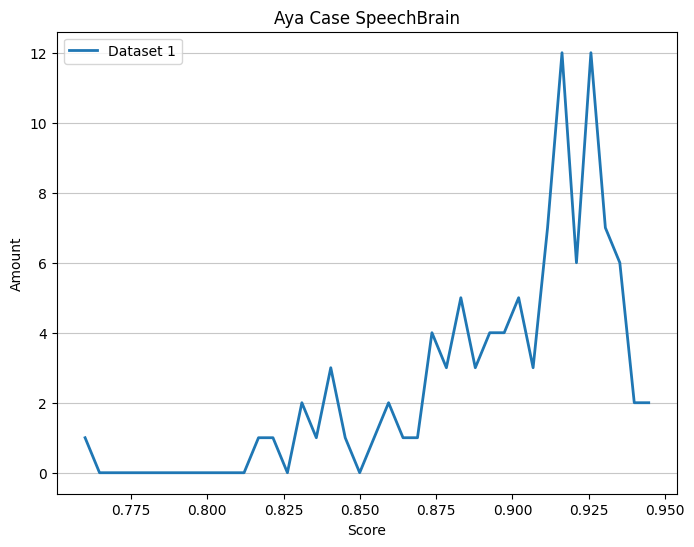

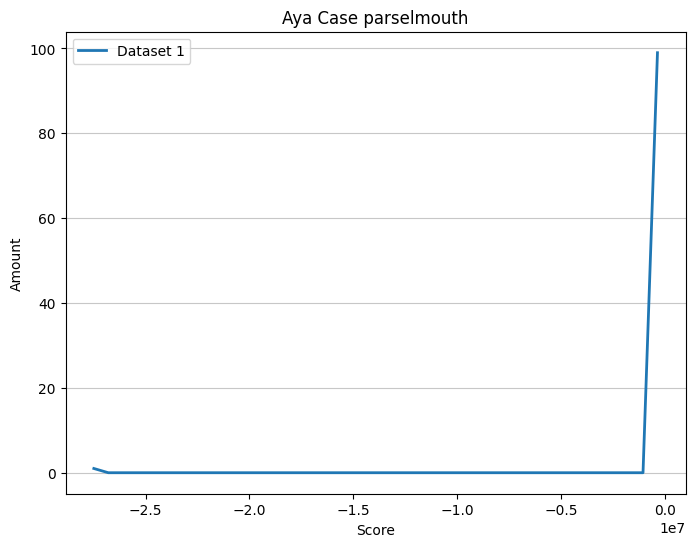

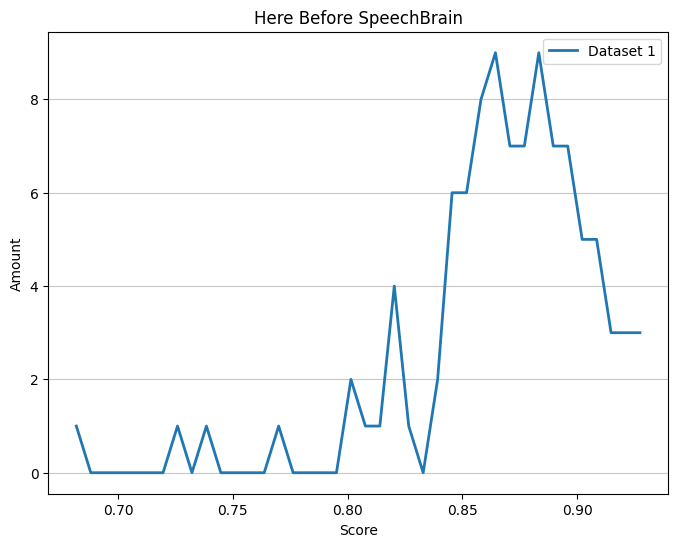

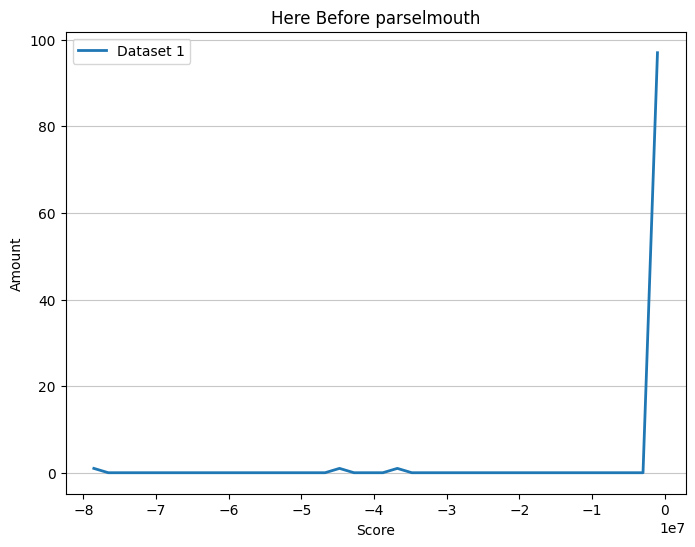

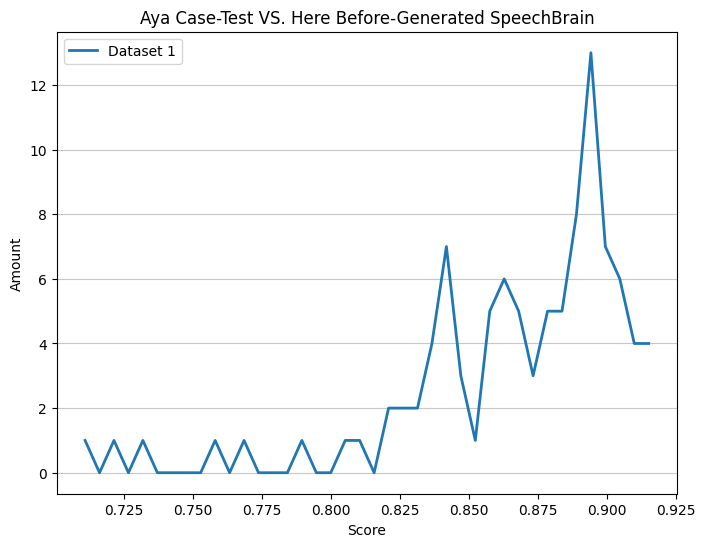

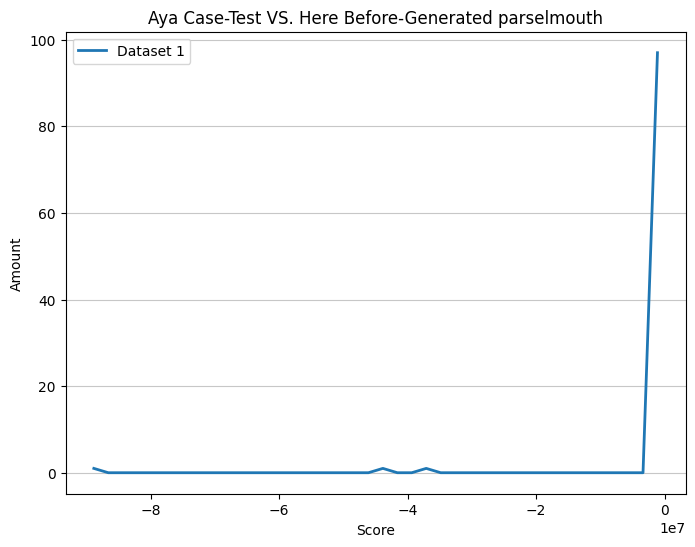

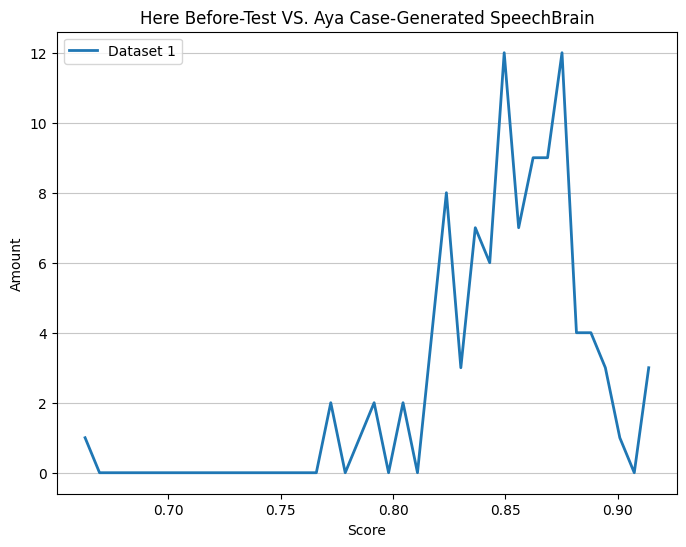

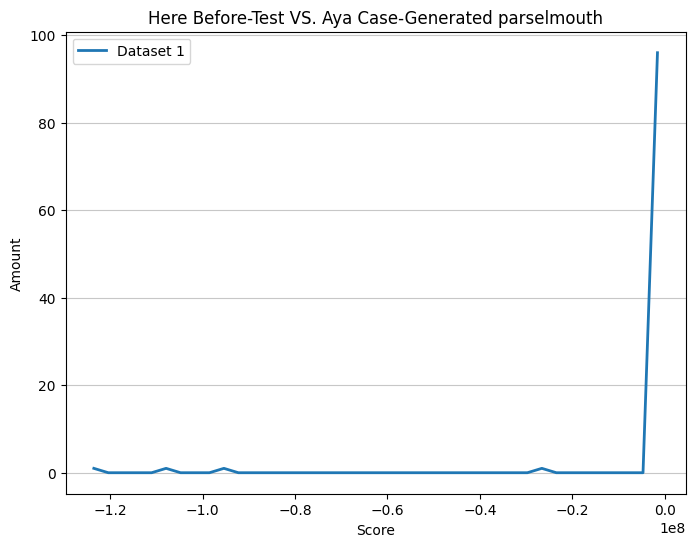

In [ ]:
######### ------------------- Don't need to Run ---------------------------------

plot_histogram([aya_case_SpeechBrain] , bins=40, title="Aya Case SpeechBrain", xlabel="Score", ylabel="Amount")
plot_histogram([aya_case_Parselmouth] , bins=40, title="Aya Case parselmouth", xlabel="Score", ylabel="Amount")

plot_histogram([here_before_SpeechBrain] , bins=40, title="Here Before SpeechBrain", xlabel="Score", ylabel="Amount")
plot_histogram([here_before_Parselmouth] , bins=40, title="Here Before parselmouth", xlabel="Score", ylabel="Amount")

plot_histogram([Test_aya_case_Gen_here_before_SpeechBrain] , bins=40, title="Aya Case-Test VS. Here Before-Generated SpeechBrain", xlabel="Score", ylabel="Amount")
plot_histogram([Test_aya_case_Gen_here_before_Parselmouth] , bins=40, title="Aya Case-Test VS. Here Before-Generated parselmouth", xlabel="Score", ylabel="Amount")

plot_histogram([Test_here_before_Gen_aya_case_SpeechBrain] , bins=40, title="Here Before-Test VS. Aya Case-Generated SpeechBrain", xlabel="Score", ylabel="Amount")
plot_histogram([Test_here_before_Gen_aya_case_Parselmouth] , bins=40, title="Here Before-Test VS. Aya Case-Generated parselmouth", xlabel="Score", ylabel="Amount")


run

In [ ]:
aya_case_SpeechBrain_dataset = [aya_case_SpeechBrain, Test_here_before_Gen_aya_case_SpeechBrain, Test_i_follow_Gen_aya_case_SpeechBrain]
aya_case_Parselmouth_dataset = [aya_case_Parselmouth, Test_here_before_Gen_aya_case_Parselmouth, Test_i_follow_Gen_aya_case_Parselmouth]
# aya_case_i_follow_SpeechBrain_dataset = [aya_case_SpeechBrain, Test_i_follow_Gen_aya_case_SpeechBrain]
# aya_case_i_follow_Parselmouth_dataset = [aya_case_Parselmouth, Test_i_follow_Gen_aya_case_Parselmouth]
aya_case_labels = ["aya case True", "aya case False- here before", "aya case False- i follow"]

here_before_SpeechBrain_dataset = [here_before_SpeechBrain, Test_aya_case_Gen_here_before_SpeechBrain, Test_i_follow_Gen_here_before_SpeechBrain]
here_before_Parselmouth_dataset = [here_before_Parselmouth, Test_aya_case_Gen_here_before_Parselmouth, Test_i_follow_Gen_here_before_Parselmouth]
# here_before_i_follow_SpeechBrain_dataset = [here_before_SpeechBrain, Test_i_follow_Gen_here_before_SpeechBrain]
# here_before_i_follow_Parselmouth_dataset = [here_before_Parselmouth, Test_i_follow_Gen_here_before_Parselmouth]
here_before_labels = ["here before True", "here before False- aya case", "here before False- i follow"]

i_follow_SpeechBrain_dataset = [i_follow_SpeechBrain, Test_aya_case_Gen_i_follow_SpeechBrain, Test_here_before_Gen_i_follow_SpeechBrain]
i_follow_Parselmouth_dataset = [i_follow_Parselmouth, Test_aya_case_Gen_i_follow_Parselmouth, Test_here_before_Gen_i_follow_Parselmouth]
# i_follow_here_before_SpeechBrain_dataset = [i_follow_SpeechBrain, Test_here_before_Gen_i_follow_SpeechBrain]
# i_follow_here_before_Parselmouth_dataset = [i_follow_Parselmouth, Test_here_before_Gen_i_follow_Parselmouth]
i_follow_labels = ["i follow True", "i follow False- aya case", "i follow False- here before"]


plot_histogram(aya_case_SpeechBrain_dataset, bins=50, title= 'Aya Case  SpeechBrain', xlabel= "scores", ylabel= "Amount", labels= aya_case_labels)
plot_histogram(aya_case_Parselmouth_dataset, bins=40, title= 'Aya Case  Parselmouth', xlabel= "scores", ylabel= "Amount", labels= aya_case_labels)
# plot_histogram(aya_case_i_follow_SpeechBrain_dataset, bins=50, title= 'Aya Case vs i_follow SpeechBrain', xlabel= "scores", ylabel= "Amount", labels= aya_case_labels)
# plot_histogram(aya_case_i_follow_Parselmouth_dataset, bins=40, title= 'Aya Case vs i follow Parselmouth', xlabel= "scores", ylabel= "Amount", labels= aya_case_labels)

plot_histogram(here_before_SpeechBrain_dataset, bins=50,title= 'Here Before  SpeechBrain', xlabel= "scores", ylabel= "Amount", labels= here_before_labels)
plot_histogram(here_before_Parselmouth_dataset, bins=40,title= 'Here Before  Parselmouth', xlabel= "scores", ylabel= "Amount", labels= here_before_labels)
# plot_histogram(here_before_i_follow_SpeechBrain_dataset, bins=50,title= 'Here Before vs i follow SpeechBrain', xlabel= "scores", ylabel= "Amount", labels= here_before_labels)
# plot_histogram(here_before_i_follow_Parselmouth_dataset, bins=40,title= 'Here Before vs i follow Parselmouth', xlabel= "scores", ylabel= "Amount", labels= here_before_labels)

plot_histogram(i_follow_SpeechBrain_dataset, bins=50, title= 'i follow  SpeechBrain', xlabel= "scores", ylabel= "Amount", labels= i_follow_labels)
plot_histogram(i_follow_Parselmouth_dataset, bins=40, title= 'i follow  Parselmouth', xlabel= "scores", ylabel= "Amount", labels= i_follow_labels)
# plot_histogram(i_follow_here_before_SpeechBrain_dataset, bins=50, title= 'i follow vs here before SpeechBrain', xlabel= "scores", ylabel= "Amount", labels= i_follow_labels)
# plot_histogram(i_follow_here_before_Parselmouth_dataset, bins=40, title= 'i follow vs here before Parselmouth', xlabel= "scores", ylabel= "Amount", labels= i_follow_labels)


NameError: name 'aya_case_SpeechBrain' is not defined